In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import collections
import itertools
import pickle
import urllib
import pymongo
import json
import operator
import regex
import pymorphy2
import re
from io import StringIO

%matplotlib inline

In [3]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, precision_recall_curve, make_scorer, roc_auc_score
from sklearn.feature_selection import RFECV, SelectKBest

/Users/aksholokhov/.anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [264]:
from parsers import arbitrary, text_utils
import artm
import hierarchy_utils

T = lambda lid, tid: "level_%d_%s" % (lid, tid)

def from_artm_tid(artm_tid):
    # This is due to hARTM bug
    if artm_tid.startswith("level_0_"):
        return (0, artm_tid[8:])
    else:
        lid, tid = artm_tid[5:].split("_", 1)
        lid = int(lid)
        return (lid, tid)

TRANSFORM_PATH = "transform.txt"
MODEL_PATH = "hartm/"
BATCH_PATH = "transform_batches/"
EXPORT_PATH = "classifier_output.csv"

english_letters = "qwertyuiopasdfghjklzxcvbnm"
russian_letters = "йцукенгшщзфывапролдячсмитьб"
non_letters = "<>№%*()-_+={[|/]}\\"
code_elements = ["return", "if", "else", "for", "while", "main", "import", "define"]
non_scipop_words = ["новость", "туториал", "недавно", "событие", "встреча", "via"]
scipop_words = ["открытие", "исследование", "ученые", "принцип"]

## Модель и документы

In [8]:
db = pymongo.MongoClient()

In [9]:
prefix_to_col_name_map = {"habr": "habrahabr", "pn": "postnauka"}

def get_document(doc_id):
    prefix, _ = doc_id.split("_", 1)
    col_name = prefix_to_col_name_map[prefix]
    return db["datasets"][col_name].find_one({"_id": doc_id})

In [10]:
all_habrahabr_ids = set(map(lambda r: r["_id"], db["datasets"]["habrahabr"].find({}, {"_id": 1})))

In [13]:
with open("reduced_habr_docs_ids.txt", "r") as f:
    reduced_habrahabr_ids = set(map(str.strip, f.readlines()))

In [21]:
almost_all_habrahabr_ids = list(all_habrahabr_ids - reduced_habrahabr_ids)

In [22]:
len(almost_all_habrahabr_ids)

60655

In [592]:
train_idx, train_data = zip(*[(row["_id"], row["is_relevant"]) for row in db["assessment"]["habrahabr"].find()
                               .sort("assess_time", 1)])
train_y = pd.Series(data=train_data, index=train_idx)
all_docs_y = list(map(lambda r: r["_id"], db["datasets"]["habrahabr"].find({}, {"_id": 1})))
train_y = train_y.map(lambda t: 1 if t else -1)

In [594]:
len(train_y[train_y == -1])

841

In [296]:
pn_docs_ids = list(map(lambda r: r["_id"], db["datasets"]["postnauka"].find({}, {"_id": 1})))

In [202]:
last_y = train_y[1000:]

In [203]:
train_y = pd.concat([train_y[train_y == 1], last_y[last_y==-1]])

In [36]:
%%time

all_docs = list(map(get_document, all_docs_y))

CPU times: user 49 s, sys: 15.7 s, total: 1min 4s
Wall time: 1min 32s


In [299]:
pn_docs = list(map(get_document, pn_docs_ids))

In [518]:
train_docs = list(map(get_document, train_y.index))

In [7]:
all_habr_docs = list(map(get_document, all_habrahabr_ids))

In [265]:
artm_model = hierarchy_utils.hARTM(theta_columns_naming="title",
                                   cache_theta=True)
artm_model.load(MODEL_PATH)

In [266]:
artm_extra_info = pickle.load(open(MODEL_PATH + "/extra_info.dump", "rb"))

In [267]:
artm_extra_info["theta"].shape

(80, 6234)

## Эксперименты со спектром

К классификатору это не относится

In [268]:
from arranging.api import arrange_topics
import arranging.api as api
from arranging.crossmin import CrossMinimizer

In [270]:
# Extract Phi, Psi and Theta matrices
phis = []
psis = []
#theta = artm_extra_info["theta"]
# theta = pickle.load(open(THETA_MODEL_PATH, "rb"))["theta"]
for level_idx, artm_level in enumerate(artm_model._levels):
    phis.append(artm_level.get_phi(class_ids="flat_tag"))
    if level_idx > 0:
        psis.append(artm_level.get_psi())
        
phi0_topic_titles = list(filter(lambda x: x.startswith("topic"), phis[0].columns))
phi1_topic_titles = list(filter(lambda x: x.startswith("topic"), phis[1].columns))

In [276]:
psis[0].index

Index(['topic_58', 'topic_6', 'topic_19', 'topic_36', 'topic_3', 'topic_59',
       'topic_30', 'topic_38', 'topic_5', 'topic_49', 'topic_0', 'topic_21',
       'topic_50', 'topic_55', 'topic_16', 'topic_2', 'topic_46', 'topic_20',
       'topic_56', 'topic_52', 'topic_24', 'topic_53', 'topic_4', 'topic_22',
       'topic_34', 'topic_26', 'topic_33', 'topic_42', 'topic_51', 'topic_45',
       'topic_18', 'topic_28', 'topic_37', 'topic_40', 'topic_12', 'topic_31',
       'topic_7', 'topic_10', 'topic_14', 'topic_1', 'topic_48', 'topic_17',
       'topic_23', 'topic_39', 'topic_43', 'topic_8', 'topic_9', 'topic_41',
       'topic_44', 'topic_13', 'topic_29', 'topic_15', 'topic_54', 'topic_35',
       'topic_32', 'topic_11', 'topic_27', 'topic_57', 'topic_25', 'topic_47'],
      dtype='object')

In [274]:
new_phi1_topic_order

array(['topic_58', 'topic_6', 'topic_19', 'topic_36', 'topic_3',
       'topic_59', 'topic_30', 'topic_38', 'topic_5', 'topic_49',
       'topic_0', 'topic_21', 'topic_50', 'topic_55', 'topic_16',
       'topic_2', 'topic_46', 'topic_20', 'topic_56', 'topic_52',
       'topic_24', 'topic_53', 'topic_4', 'topic_22', 'topic_34',
       'topic_26', 'topic_33', 'topic_42', 'topic_51', 'topic_45',
       'topic_18', 'topic_28', 'topic_37', 'topic_40', 'topic_12',
       'topic_31', 'topic_7', 'topic_10', 'topic_14', 'topic_1',
       'topic_48', 'topic_17', 'topic_23', 'topic_39', 'topic_43',
       'topic_8', 'topic_9', 'topic_41', 'topic_44', 'topic_13',
       'topic_29', 'topic_15', 'topic_54', 'topic_35', 'topic_32',
       'topic_11', 'topic_27', 'topic_57', 'topic_25', 'topic_47'], 
      dtype='<U8')

In [272]:
new_phi1_topic_order = np.array(phi1_topic_titles)[arrange_topics(phis[1][phi1_topic_titles].values)]
phis[1] = phis[1][new_phi1_topic_order]
psis[0] = psis[0].loc[new_phi1_topic_order]

In [277]:
children_threshold = 0.05

D = np.zeros((len(phi0_topic_titles), len(phi1_topic_titles)))

for parent_id, parent in enumerate(phi0_topic_titles):
    for child_id, maybe_child in enumerate(phi1_topic_titles):
        if psis[0].loc[maybe_child, parent] > children_threshold:
            D[parent_id, child_id] = 1

In [278]:
cm = CrossMinimizer(D)
idx = cm.solve(mode="auto", model=None)
new_phi0_topic_order = np.array(phi1_topic_titles)[idx]

In [279]:
new_phi0_topic_order

array(['topic_3', 'topic_1', 'topic_7', 'topic_9', 'topic_10', 'topic_12',
       'topic_2', 'topic_4', 'topic_13', 'topic_11', 'topic_17',
       'topic_16', 'topic_6', 'topic_14', 'topic_18', 'topic_5', 'topic_0',
       'topic_15', 'topic_8'], 
      dtype='<U8')

In [280]:
new_phi1_topic_order

array(['topic_58', 'topic_6', 'topic_19', 'topic_36', 'topic_3',
       'topic_59', 'topic_30', 'topic_38', 'topic_5', 'topic_49',
       'topic_0', 'topic_21', 'topic_50', 'topic_55', 'topic_16',
       'topic_2', 'topic_46', 'topic_20', 'topic_56', 'topic_52',
       'topic_24', 'topic_53', 'topic_4', 'topic_22', 'topic_34',
       'topic_26', 'topic_33', 'topic_42', 'topic_51', 'topic_45',
       'topic_18', 'topic_28', 'topic_37', 'topic_40', 'topic_12',
       'topic_31', 'topic_7', 'topic_10', 'topic_14', 'topic_1',
       'topic_48', 'topic_17', 'topic_23', 'topic_39', 'topic_43',
       'topic_8', 'topic_9', 'topic_41', 'topic_44', 'topic_13',
       'topic_29', 'topic_15', 'topic_54', 'topic_35', 'topic_32',
       'topic_11', 'topic_27', 'topic_57', 'topic_25', 'topic_47'], 
      dtype='<U8')

In [281]:
def get_topic_name(lid, tid):
    return ", ".join(phis[lid][tid].sort_values()[-3:][::-1].index)

In [282]:
print("\n".join(map(lambda t: t + " \t" + get_topic_name(0, t), new_phi0_topic_order)))

topic_3 	культура, литература, культурология
topic_1 	медицина, эволюция, антропология
topic_7 	социология, социология_повседневности, дюркгейм_эмиль
topic_9 	психология, люди_науки, история_науки
topic_10 	палеонтология, биохимия, стволовые_клетки
topic_12 	наука, управление_проектами, работа
topic_2 	информационная_безопасность, копирайт, будущее
topic_4 	история, история_россии, ссср
topic_13 	химия, нанотехнологии, материаловедение
topic_11 	физика, физика_элементарных_частиц, квантовая_физика
topic_17 	экология, зоология, этология
topic_16 	средневековье, мифология, биоинформатика
topic_6 	лингвистика, язык, право
topic_14 	образование, университет, школа
topic_18 	мозг, нейробиология, искусственный_интеллект
topic_5 	астрономия, астрофизика, вселенная
topic_0 	философия, россия, география
topic_15 	математика, информационные_технологии, технологии
topic_8 	общество, экономика, россия


In [284]:
print("\n".join(map(lambda t: t + " \t" + get_topic_name(0, t), phi0_topic_titles)))

topic_0 	философия, россия, география
topic_1 	медицина, эволюция, антропология
topic_2 	информационная_безопасность, копирайт, будущее
topic_3 	культура, литература, культурология
topic_4 	история, история_россии, ссср
topic_5 	астрономия, астрофизика, вселенная
topic_6 	лингвистика, язык, право
topic_7 	социология, социология_повседневности, дюркгейм_эмиль
topic_8 	общество, экономика, россия
topic_9 	психология, люди_науки, история_науки
topic_10 	палеонтология, биохимия, стволовые_клетки
topic_11 	физика, физика_элементарных_частиц, квантовая_физика
topic_12 	наука, управление_проектами, работа
topic_13 	химия, нанотехнологии, материаловедение
topic_14 	образование, университет, школа
topic_15 	математика, информационные_технологии, технологии
topic_16 	средневековье, мифология, биоинформатика
topic_17 	экология, зоология, этология
topic_18 	мозг, нейробиология, искусственный_интеллект


In [286]:
len(phi0_topic_titles)

19

In [287]:
phi0_flat_spectrum = np.array(phi0_topic_titles)[arrange_topics(phis[0][phi0_topic_titles].values)]

In [288]:
print("\n".join(map(lambda t: t + " \t" + get_topic_name(0, t), phi0_flat_spectrum)))

topic_13 	химия, нанотехнологии, материаловедение
topic_5 	астрономия, астрофизика, вселенная
topic_11 	физика, физика_элементарных_частиц, квантовая_физика
topic_15 	математика, информационные_технологии, технологии
topic_10 	палеонтология, биохимия, стволовые_клетки
topic_2 	информационная_безопасность, копирайт, будущее
topic_16 	средневековье, мифология, биоинформатика
topic_4 	история, история_россии, ссср
topic_8 	общество, экономика, россия
topic_0 	философия, россия, география
topic_3 	культура, литература, культурология
topic_6 	лингвистика, язык, право
topic_7 	социология, социология_повседневности, дюркгейм_эмиль
topic_12 	наука, управление_проектами, работа
topic_14 	образование, университет, школа
topic_9 	психология, люди_науки, история_науки
topic_18 	мозг, нейробиология, искусственный_интеллект
topic_17 	экология, зоология, этология
topic_1 	медицина, эволюция, антропология


In [259]:
# Двухуровневый спектр
pickle.dump((new_phi0_topic_order, new_phi1_topic_order, D), open("spectrum.dump", "wb"))

In [290]:
# Одноуровневый спектр
level_0_topics_ids = list(map(lambda tid: "level_0_%s" % tid, phi0_flat_spectrum))
pickle.dump(level_0_topics_ids, open("flat_spectrum.dump", "wb"))

### Генерация признаков

In [519]:
%%time

docs_info = []
docs_texts = []

pipeline = arbitrary.get_pipeline()

counter = 0

for doc in train_docs:
    doc_features = {}
    text = doc["modalities"]["text"] + doc["modalities"]["text_habr"]
    # Количественные признаки
    doc_features["words_count"] = len(text) # Число слов в документе
    doc_features["unique_words_ratio"] = len(set(text))/len(text)
    doc_features["common_words_ratio"] = len(doc["modalities"]["text"]) / len(text) # Доля токенов в документе из ПН
    doc_features["en_words"] = len([a for a in text if regex.match("^[a-zA-Z]+$", a)])/len(text)
    doc_features["ru_words"] = len([a for a in text if regex.match("^[а-яА-Я]+$", a)])/len(text)
    doc_features["non_letters"] = len([a for a in doc["markdown"] if a in non_letters])/len(doc["markdown"])
    doc_features["non_scipop_words"] = len([a for a in text if a in non_scipop_words])
    doc_features["scipop_words"] = len([a for a in text if a in scipop_words])
    # Параграфы и их длины
    doc_features["num_of_paragraphs"] = len([a for a in doc["markdown"].split('\n') if len(a) != 0])
    doc_features["paragraph_raito"] = doc_features["num_of_paragraphs"] / len(text)
    doc_features["avg_paragraph_len"] = np.mean([len(a) for a in doc["markdown"].split('\n') if len(a) != 0])
    doc_features["num_of_small_paragraphs"] = sum([1 for a in doc["markdown"].split('\n')
                                               if len(a) < 300 and len(a) > 0 or len(a.split(" ")) < 30])
    doc_features["num_of_large_paragraphs"] = sum([1 for a in doc["markdown"].split('\n')
                                               if len(a) > 1300 or len(a.split(" ")) > 120])
    doc_features["small_paragraphs_ratio"] = doc_features["num_of_small_paragraphs"]/doc_features["num_of_paragraphs"]
    doc_features["large_paragraphs_ratio"] = doc_features["num_of_large_paragraphs"]/doc_features["num_of_paragraphs"]
    doc_features["paragraphs_variance"] = np.var([len(s) for s in doc["markdown"].split('\n') if len(a) != 0])

    # Фичи заголовков:
    
    #doc_features["code_ratio"] = len([a for a in doc["markdown"].split("\t") if a in code_elements])/len(doc["markdown"])
    docs_info.append(doc_features)
    docs_texts.append(text)
    
train_X = pd.DataFrame(data=docs_info, index=train_y.index)

CPU times: user 4.81 s, sys: 383 ms, total: 5.19 s
Wall time: 5.02 s


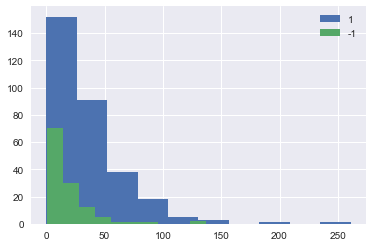

In [273]:
plt.hist(train_X[train_y == 1]["INFN"], label="1")
plt.hist(train_X[train_y == -1]["INFN"], label="-1")
plt.legend()
plt.show()

In [270]:
train_X.describe()

,avg_paragraph_len,common_words_ratio,en_words,large_paragraphs_ratio,non_letters,non_scipop_words,num_of_large_paragraphs,num_of_paragraphs,num_of_small_paragraphs,paragraph_raito,...,NUMR,futr,impf,past,perf,plur,pres,sing,verbs_in_first_pars,verbs_in_title
count,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,...,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000
mean,205.712119,0.864115,0.134659,0.016980,0.013726,0.542923,0.457077,55.890951,49.169374,0.105260,...,2.647332,12.535963,69.879350,33.227378,51.714617,137.016241,48.672854,359.074246,1.793503,0.099768
std,125.266391,0.115835,0.156339,0.055188,0.034144,1.107013,1.220899,90.555108,89.295676,0.134939,...,4.021568,15.781001,63.538996,39.540962,47.021220,129.493853,44.450570,325.571946,2.268399,0.315160
min,9.841549,0.356061,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.016393,...,0.000000,0.000000,5.000000,1.000000,3.000000,6.000000,3.000000,28.000000,0.000000,0.000000
25%,103.760204,0.818026,0.020263,0.000000,0.003701,0.000000,0.000000,14.000000,9.000000,0.046281,...,0.000000,3.000000,28.000000,12.000000,21.000000,53.000000,18.000000,144.500000,0.000000,0.000000
50%,190.457143,0.902354,0.075711,0.000000,0.005846,0.000000,0.000000,27.000000,19.000000,0.069519,...,1.000000,8.000000,52.000000,21.000000,39.000000,99.000000,37.000000,266.000000,1.000000,0.000000
75%,283.083333,0.948319,0.195529,0.000000,0.012924,1.000000,0.000000,56.000000,48.000000,0.121462,...,3.000000,16.500000,90.500000,39.000000,67.000000,177.500000,62.000000,439.500000,3.000000,0.000000
max,714.444444,1.000000,0.833333,0.500000,0.638132,9.000000,9.000000,1091.000000,1075.000000,2.151515,...,27.000000,164.000000,539.000000,424.000000,333.000000,1286.000000,329.000000,2818.000000,22.000000,2.000000


In [207]:
docs_info = []

for doc in train_docs:
    doc = pipeline.fit_transform(StringIO(doc["markdown"]))
    vw_file = open(TRANSFORM_PATH, "w")
    text_utils.VowpalWabbitSink(vw_file, lambda x: "upload") \
                          .fit_transform([doc])
    transform_batch = artm.BatchVectorizer(data_format="vowpal_wabbit",
                                                       data_path=TRANSFORM_PATH,
                                                       batch_size=1,
                                                       target_folder=BATCH_PATH)
    transform_theta = artm_model.transform(transform_batch)
    
    theta = {}
    for artm_tid, prob in transform_theta["upload"].items():
        topic_id = T(*from_artm_tid(artm_tid))
        theta[topic_id] = float(prob)    
    docs_info.append(theta)
    
    counter+=1;
    if counter % 100 == 0:
        print("proceeded: %d"%((counter)))
        
thetas = pd.DataFrame(data=docs_info, index=train_y.index)

proceeded: 100
proceeded: 200
proceeded: 300
proceeded: 400


In [208]:
train_X["theta_max"] = thetas.max(axis=1)  #максимальное значение theta для каждого файла из хабра
train_X["num_of_big_thetas_0"] = thetas[thetas > 0.2].count(axis=1)
train_X["num_of_big_thetas_1"] = thetas[thetas > 0.1].count(axis=1)
train_X["num_of_big_thetas_2"] = thetas[thetas > 0.05].count(axis=1)

In [26]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

import re

morph_tags = [
    "past",
    "pres",
    "futr",
    "INFN",
    "NOUN",
    "ADJF",
    "COMP",
    "NPRO",
    "NUMR",
    "sing",
    "plur",
    "LATN",
    "perf",
    "impf",
    "1per",
    "2per",
    "3per"
]

In [520]:
docs_info = []


counter = 0

for doc in train_docs:
    text = doc["markdown"]
    tokens = re.findall(r"[\w']+", text)
    doc_features = dict(zip(morph_tags, np.zeros(len(morph_tags))))
    npro1 = 0
    for token in tokens:
        parse_result = morph.parse(token)[0]
        for tag in doc_features.keys():
            if tag in parse_result.tag:
                doc_features[tag] += 1
            if {"NPRO", "1per"} in parse_result.tag:
                npro1 += 1
    doc_features["NPRO1"] = npro1

    doc_features["verbs_in_title"] = 0
    for token in re.findall(r"[\w']+", doc["title"]):
        parse_result = morph.parse(token)[0]
        if ({"VERB", "past"} in parse_result.tag) | ({"VERB", "futr"} in parse_result.tag): 
            doc_features["verbs_in_title"] += 1
            
    doc_features["verbs_in_first_pars"] = 0
    first_paragraphs = text.split("\n")[0]
    for token in re.findall(r"[\w']+", first_paragraphs):
        parse_result = morph.parse(token)[0]
        if ({"VERB", "past"} in parse_result.tag) | ({"VERB", "futr"} in parse_result.tag): 
            doc_features["verbs_in_first_pars"] += 1
        
    docs_info.append(doc_features)
        
    counter += 1
    if counter % 50 == 0:
        print("proceded: %d"%((counter)))
    
morph_features = pd.DataFrame(data=docs_info, index=train_y.index)

proceded: 50
proceded: 100
proceded: 150
proceded: 200
proceded: 250
proceded: 300
proceded: 350
proceded: 400
proceded: 450
proceded: 500
proceded: 550
proceded: 600
proceded: 650
proceded: 700
proceded: 750
proceded: 800
proceded: 850
proceded: 900
proceded: 950
proceded: 1000
proceded: 1050
proceded: 1100
proceded: 1150


In [521]:
train_X = pd.concat([train_X, morph_features], axis=1)

### Подбор модели

In [35]:
good_features = [#"common_words_ratio",
                 #"words_count",
                 #"theta_max", 
                 #"num_of_big_thetas_0", "num_of_big_thetas_1",
                 #"num_of_big_thetas_2",
                 "unique_words_ratio",
                 "en_words", "ru_words",# "non_letters",
                 "scipop_words", "non_scipop_words",
                 "num_of_paragraphs",
                 "paragraph_raito", "avg_paragraph_len",
                 "num_of_small_paragraphs", "num_of_large_paragraphs", 
                 "small_paragraphs_ratio",
                 "large_paragraphs_ratio",
                 "verbs_in_title", "verbs_in_first_pars",
                 'non_letters', 'paragraphs_variance'
                ] + [
                    "past",
                    "pres",
                    "futr",
                    "INFN",
                    "NOUN",
                    "ADJF",
                    "COMP",
                    "NPRO",
                    "NPRO1",
                    "NUMR",
                    "sing",
                    "plur",
                    "LATN",
                    "perf",
                    "impf",
                    "1per",
                    "2per",
                    "3per"
                ]

In [544]:
alg = RandomForestClassifier(n_estimators=30)
alg.fit(train_X[good_features][-150:], train_y[-150:])
#alg = GradientBoostingClassifier(n_estimators=54)
#alg = LogisticRegression()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [527]:
cross_val_score(alg, train_X[good_features], train_y, scoring=make_scorer(roc_auc_score), cv=10).mean()

0.68771030993042381

In [529]:
pred_y = alg.predict(train_X[good_features])

In [530]:
accuracy_score(train_y, pred_y)

0.99739130434782608

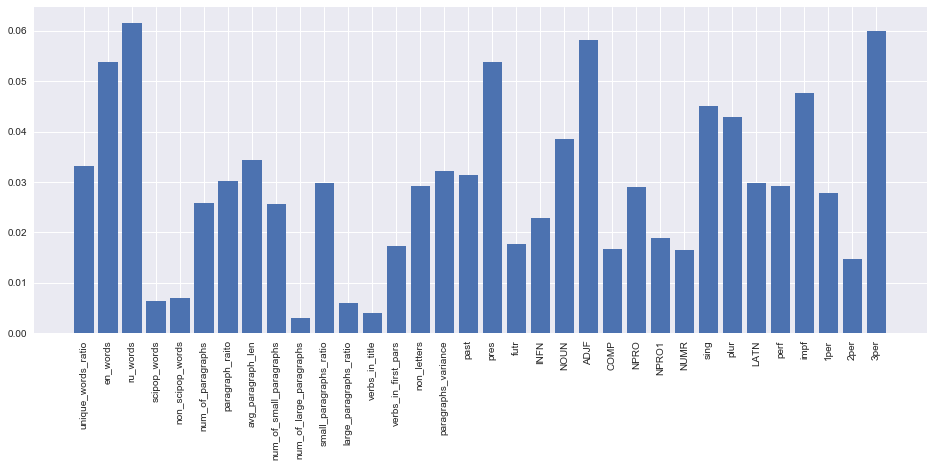

In [531]:
importances = alg.feature_importances_
plt.figure(figsize=(16, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), good_features, rotation="vertical")
plt.show()

## Обучение на совмещенной с хабром постнауке

In [720]:
def generate_X(ids, features=good_features):
    docs = list(map(get_document, ids))
    
    docs_info = []

    pipeline = arbitrary.get_pipeline()

    counter = 0

    for doc in docs:
        doc_features = {}

        text = doc["modalities"]["text"] + doc["modalities"]["text_habr"]
        # Количественные признаки
        doc_features["words_count"] = len(text) # Число слов в документе
        doc_features["unique_words_ratio"] = len(set(text))/len(text)
        doc_features["common_words_ratio"] = len(doc["modalities"]["text"]) / len(text) # Доля токенов в документе из ПН
        doc_features["en_words"] = len([a for a in text if regex.match("^[a-zA-Z]+$", a)])/len(text)
        doc_features["ru_words"] = len([a for a in text if regex.match("^[а-яА-Я]+$", a)])/len(text)
        doc_features["non_letters"] = len([a for a in doc["markdown"] if a in non_letters])/len(doc["markdown"])
        doc_features["non_scipop_words"] = len([a for a in text if a in non_scipop_words])
        doc_features["scipop_words"] = len([a for a in text if a in scipop_words])
        # Параграфы и их длины
        doc_features["num_of_paragraphs"] = len([a for a in doc["markdown"].split('\n') if len(a) != 0])
        doc_features["paragraph_raito"] = doc_features["num_of_paragraphs"] / len(text)
        doc_features["avg_paragraph_len"] = np.mean([len(a) for a in doc["markdown"].split('\n') if len(a) != 0])
        doc_features["num_of_small_paragraphs"] = sum([1 for a in doc["markdown"].split('\n')
                                                   if len(a) < 300 and len(a) > 0 or len(a.split(" ")) < 30])
        doc_features["num_of_large_paragraphs"] = sum([1 for a in doc["markdown"].split('\n')
                                                   if len(a) > 1300 or len(a.split(" ")) > 120])
        doc_features["small_paragraphs_ratio"] = doc_features["num_of_small_paragraphs"]/doc_features["num_of_paragraphs"]
        doc_features["large_paragraphs_ratio"] = doc_features["num_of_large_paragraphs"]/doc_features["num_of_paragraphs"]
        doc_features["paragraphs_variance"] = np.var([len(s) for s in doc["markdown"].split('\n') if len(a) != 0])

        # Фичи заголовков:

        #doc_features["code_ratio"] = len([a for a in doc["markdown"].split("\t") if a in code_elements])/len(doc["markdown"])

        text = doc["markdown"]
        tokens = re.findall(r"[\w']+", text)
        npro1 = 0
        
        for tag in morph_tags:
            doc_features[tag] = 0
            
        for token in tokens:
            parse_result = morph.parse(token)[0]
            for tag in morph_tags:
                if tag in parse_result.tag:
                    doc_features[tag] += 1
                if {"NPRO", "1per"} in parse_result.tag:
                    npro1 += 1
        doc_features["NPRO1"] = npro1

        doc_features["verbs_in_title"] = 0
        for token in re.findall(r"[\w']+", doc["title"]):
            parse_result = morph.parse(token)[0]
            if ({"VERB", "past"} in parse_result.tag) | ({"VERB", "futr"} in parse_result.tag): 
                doc_features["verbs_in_title"] += 1

        doc_features["verbs_in_first_pars"] = 0
        first_paragraphs = text.split("\n")[0]
        for token in re.findall(r"[\w']+", first_paragraphs):
            parse_result = morph.parse(token)[0]
            if ({"VERB", "past"} in parse_result.tag) | ({"VERB", "futr"} in parse_result.tag): 
                doc_features["verbs_in_first_pars"] += 1

        docs_info.append(doc_features)
        
    return pd.DataFrame(data=docs_info, index=ids)

In [721]:
small_good_X = generate_X(small_good_ids)

In [735]:
small_good_y = np.array([1]*len(small_good_X))

In [711]:
small_good_ids = list(map(lambda r: r["_id"], [{"_id" : "habr_67216" },
{ "_id" : "habr_117907" },
{ "_id" : "habr_11871" },
{ "_id" : "habr_113675" },
{ "_id" : "habr_7052" }]))

In [712]:
small_good_ids

['habr_67216', 'habr_117907', 'habr_11871', 'habr_113675', 'habr_7052']

In [641]:
positives_habr = len(train_y[train_y == 1])

In [642]:
positives_habr

309

In [745]:
pickle.dump(pnh_train_y, open("classifier_train_ids.dump", "wb"))

In [746]:
pickle.dump(alg, open("best_classifier.dump", "wb"))

In [646]:
pnh_train_y = pd.concat([train_y[train_y == 1], 
                         pd.Series(np.ones(positives_habr), index=pn_X[:positives_habr].index),
                         train_y[train_y==-1][:2*positives_habr]
                        ])

In [654]:
pnh_train_X = pd.concat([train_X[train_y == 1],
                         postnauka_X[:positives_habr],
                         train_X[train_y==-1][:2*positives_habr]
                        ])

In [695]:
pnh_test_X = pd.concat([#train_X[train_y == -1][2*positives_habr:],
                        postnauka_X[positives_habr:]])

In [699]:
pnh_test_Y = [1]*(len(postnauka_X) - positives_habr)
#[-1]*(len(train_X[train_y == -1]) - 2*positives_habr)

(array([    0.,     0.,     0.,     0.,     0.,  2667.,     0.,     0.,
            0.,     0.]),
 array([ 0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5]),
 <a list of 10 Patch objects>)

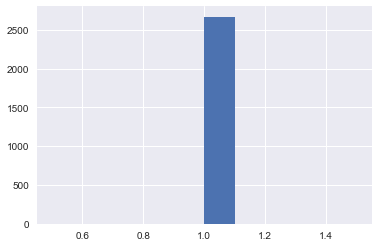

In [700]:
plt.hist(pnh_test_Y)

(array([ 618.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  618.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

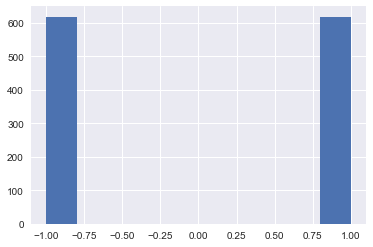

In [701]:
plt.hist(pnh_train_y)

In [771]:
?RandomForestClassifier

In [853]:
alg = RandomForestClassifier(n_estimators=30, random_state=43)

In [854]:
cross_val_score(alg, pnh_train_X[good_features], pnh_train_y, scoring=make_scorer(accuracy_score)).mean()

0.77588996763754048

In [855]:
alg.fit(pnh_train_X[good_features], pnh_train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=43,
            verbose=0, warm_start=False)

In [856]:
len(pnh_test_X), len(pnh_test_Y)

(2667, 2667)

In [864]:
prediction = alg.predict_proba(small_good_X[good_features])

In [865]:
prediction

array([[ 0.53333333,  0.46666667],
       [ 0.23333333,  0.76666667],
       [ 0.06666667,  0.93333333],
       [ 0.66666667,  0.33333333],
       [ 0.2       ,  0.8       ]])

(array([   62.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2605.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

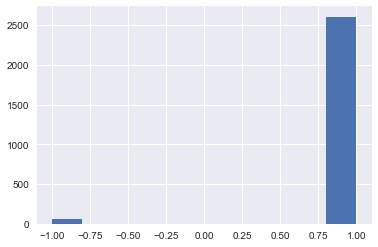

In [860]:
plt.hist(prediction)

In [861]:
np.mean(prediction==1)

0.97675290588676411

## Тест на постнауке

In [624]:
docs_info = []
docs_texts = []

pipeline = arbitrary.get_pipeline()

counter = 0

for doc in pn_docs:
    doc_features = {}
    text = doc["modalities"]["text"] #+ doc["modalities"]["text_habr"]
    # Количественные признаки
    doc_features["words_count"] = len(text) # Число слов в документе
    doc_features["unique_words_ratio"] = len(set(text))/len(text)
    #doc_features["common_words_ratio"] = len(doc["modalities"]["text"]) / len(text) # Доля токенов в документе из ПН
    doc_features["en_words"] = len([a for a in text if regex.match("^[a-zA-Z]+$", a)])/len(text)
    doc_features["ru_words"] = len([a for a in text if regex.match("^[а-яА-Я]+$", a)])/len(text)
    doc_features["non_letters"] = len([a for a in doc["markdown"] if a in non_letters])/len(doc["markdown"])
    doc_features["non_scipop_words"] = len([a for a in text if a in non_scipop_words])
    doc_features["scipop_words"] = len([a for a in text if a in scipop_words])
    # Параграфы и их длины
    doc_features["num_of_paragraphs"] = len([a for a in doc["markdown"].split('\n') if len(a) != 0])
    doc_features["paragraph_raito"] = doc_features["num_of_paragraphs"] / len(text)
    doc_features["avg_paragraph_len"] = np.mean([len(a) for a in doc["markdown"].split('\n') if len(a) != 0])
    doc_features["num_of_small_paragraphs"] = sum([1 for a in doc["markdown"].split('\n')
                                               if (len(a) < 300 or len(a.split(" ")) < 30) and len(a) != 0])
    doc_features["num_of_large_paragraphs"] = sum([1 for a in doc["markdown"].split('\n')
                                               if (len(a) > 1300 or len(a.split(" ")) > 120) and len(a) != 0])
    doc_features["small_paragraphs_ratio"] = doc_features["num_of_small_paragraphs"]/doc_features["num_of_paragraphs"]
    doc_features["large_paragraphs_ratio"] = doc_features["num_of_large_paragraphs"]/doc_features["num_of_paragraphs"]
    doc_features["paragraphs_variance"] = np.var([len(s) for s in doc["markdown"].split('\n') if len(a) != 0])

    # Фичи заголовков:
    
    #doc_features["code_ratio"] = len([a for a in doc["markdown"].split("\t") if a in code_elements])/len(doc["markdown"])
    docs_info.append(doc_features)
    docs_texts.append(text)
    
pn_X = pd.DataFrame(data=docs_info, index=pn_docs_ids)

In [420]:
pn_X.describe()

,avg_paragraph_len,en_words,large_paragraphs_ratio,non_letters,non_scipop_words,num_of_large_paragraphs,num_of_paragraphs,num_of_small_paragraphs,paragraph_raito,paragraphs_variance,ru_words,scipop_words,small_paragraphs_ratio,unique_words_ratio,words_count
count,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2.976000e+03,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000
mean,526.372729,0.013795,0.162901,0.002902,0.800067,2.683804,17.322917,6.812836,0.031007,1.403133e+05,0.986007,0.991935,0.321287,0.625829,594.246640
std,194.431228,0.022010,0.183548,0.002465,3.515346,3.630101,18.028108,10.828390,0.016028,1.187894e+05,0.022212,2.085871,0.187621,0.108649,606.800107
min,51.853659,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.008075,2.444108e+03,0.734724,0.000000,0.000000,0.264488,97.000000
25%,400.480159,0.000000,0.000000,0.001520,0.000000,0.000000,4.000000,1.000000,0.022989,6.979072e+04,0.982275,0.000000,0.217391,0.546019,168.000000
50%,489.847368,0.006315,0.111111,0.002357,0.000000,1.000000,13.000000,3.000000,0.028923,1.110315e+05,0.993631,0.000000,0.250000,0.620976,485.000000
75%,616.393725,0.017248,0.250000,0.003619,1.000000,4.000000,23.000000,10.000000,0.035481,1.723721e+05,1.000000,1.000000,0.433696,0.711031,732.000000
max,1838.833333,0.264903,1.000000,0.044720,114.000000,33.000000,287.000000,268.000000,0.225275,1.776580e+06,1.000000,27.000000,1.000000,0.936937,6294.000000


In [418]:
train_X.describe()

,avg_paragraph_len,common_words_ratio,en_words,large_paragraphs_ratio,non_letters,non_scipop_words,num_of_large_paragraphs,num_of_paragraphs,num_of_small_paragraphs,paragraph_raito,paragraphs_variance,ru_words,scipop_words,small_paragraphs_ratio,unique_words_ratio,words_count
count,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.000000,431.00000
mean,205.712119,0.864115,0.134659,0.016980,0.013726,0.542923,0.457077,55.890951,49.169374,0.105260,33888.503936,0.864713,0.417633,0.734376,0.629286,502.99536
std,125.266391,0.115835,0.156339,0.055188,0.034144,1.107013,1.220899,90.555108,89.295676,0.134939,46922.613169,0.156137,0.816723,0.232629,0.130119,444.65714
min,9.841549,0.356061,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.016393,786.013605,0.166667,0.000000,0.000000,0.175604,101.00000
25%,103.760204,0.818026,0.020263,0.000000,0.003701,0.000000,0.000000,14.000000,9.000000,0.046281,9957.125988,0.804471,0.000000,0.574176,0.548638,207.00000
50%,190.457143,0.902354,0.075711,0.000000,0.005846,0.000000,0.000000,27.000000,19.000000,0.069519,20206.759003,0.922764,0.000000,0.785714,0.643478,380.00000
75%,283.083333,0.948319,0.195529,0.000000,0.012924,1.000000,0.000000,56.000000,48.000000,0.121462,37429.829234,0.978333,1.000000,0.938138,0.722199,600.50000
max,714.444444,1.000000,0.833333,0.500000,0.638132,9.000000,9.000000,1091.000000,1075.000000,2.151515,443556.000000,1.000000,6.000000,1.000000,0.884211,3745.00000


In [314]:
morph = pymorphy2.MorphAnalyzer()

docs_info = []

counter = 0

for doc in pn_docs:
    text = doc["markdown"]
    tokens = re.findall(r"[\w']+", text)
    doc_features = dict(zip(morph_tags, np.zeros(len(morph_tags))))
    npro1 = 0
    for token in tokens:
        parse_result = morph.parse(token)[0]
        for tag in doc_features.keys():
            if tag in parse_result.tag:
                doc_features[tag] += 1
            if {"NPRO", "1per"} in parse_result.tag:
                npro1 += 1
    doc_features["NPRO1"] = npro1

    doc_features["verbs_in_title"] = 0
    for token in re.findall(r"[\w']+", doc["title"]):
        parse_result = morph.parse(token)[0]
        if ({"VERB", "past"} in parse_result.tag) | ({"VERB", "futr"} in parse_result.tag): 
            doc_features["verbs_in_title"] += 1
            
    doc_features["verbs_in_first_pars"] = 0
    first_paragraphs = text.split("\n")[0]
    for token in re.findall(r"[\w']+", first_paragraphs):
        parse_result = morph.parse(token)[0]
        if ({"VERB", "past"} in parse_result.tag) | ({"VERB", "futr"} in parse_result.tag): 
            doc_features["verbs_in_first_pars"] += 1
        
    docs_info.append(doc_features)
        
    counter += 1
    if counter % 50 == 0:
        print("proceded: %d"%((counter)))
    
pn_morph_features = pd.DataFrame(data=docs_info, index=pn_docs_ids)

proceded: 50
proceded: 100
proceded: 150
proceded: 200
proceded: 250
proceded: 300
proceded: 350
proceded: 400
proceded: 450
proceded: 500
proceded: 550
proceded: 600
proceded: 650
proceded: 700
proceded: 750
proceded: 800
proceded: 850
proceded: 900
proceded: 950
proceded: 1000
proceded: 1050
proceded: 1100
proceded: 1150
proceded: 1200
proceded: 1250
proceded: 1300
proceded: 1350
proceded: 1400
proceded: 1450
proceded: 1500
proceded: 1550
proceded: 1600
proceded: 1650
proceded: 1700
proceded: 1750
proceded: 1800
proceded: 1850
proceded: 1900
proceded: 1950
proceded: 2000
proceded: 2050
proceded: 2100
proceded: 2150
proceded: 2200
proceded: 2250
proceded: 2300
proceded: 2350
proceded: 2400
proceded: 2450
proceded: 2500
proceded: 2550
proceded: 2600
proceded: 2650
proceded: 2700
proceded: 2750
proceded: 2800
proceded: 2850
proceded: 2900
proceded: 2950


In [350]:
pn_morph_features

,1per,2per,3per,ADJF,COMP,INFN,LATN,NOUN,NPRO,NPRO1,NUMR,futr,impf,past,perf,plur,pres,sing,verbs_in_first_pars,verbs_in_title
pn_2,13.0,0.0,45.0,251.0,1.0,28.0,72.0,568.0,28.0,119,2.0,3.0,79.0,71.0,70.0,321.0,59.0,638.0,5,0
pn_3,14.0,10.0,78.0,174.0,5.0,47.0,0.0,370.0,45.0,119,2.0,6.0,122.0,61.0,65.0,183.0,88.0,549.0,4,0
pn_4,43.0,4.0,154.0,450.0,7.0,46.0,12.0,977.0,72.0,391,12.0,22.0,189.0,94.0,123.0,519.0,151.0,1259.0,0,0
pn_5,39.0,2.0,106.0,364.0,5.0,49.0,29.0,701.0,71.0,391,7.0,11.0,148.0,68.0,97.0,356.0,125.0,980.0,0,0
pn_6,35.0,0.0,71.0,300.0,10.0,28.0,47.0,630.0,38.0,374,5.0,7.0,117.0,47.0,56.0,376.0,94.0,746.0,3,0
pn_7,40.0,4.0,85.0,280.0,3.0,33.0,36.0,484.0,55.0,442,6.0,7.0,121.0,61.0,65.0,261.0,98.0,724.0,1,0
pn_8,4.0,0.0,51.0,240.0,0.0,20.0,2.0,490.0,36.0,34,2.0,0.0,85.0,101.0,70.0,158.0,36.0,747.0,7,0
pn_9,7.0,0.0,82.0,168.0,3.0,27.0,2.0,358.0,47.0,85,11.0,3.0,97.0,92.0,76.0,234.0,56.0,493.0,4,0
pn_13,25.0,8.0,63.0,150.0,0.0,29.0,62.0,305.0,51.0,272,1.0,3.0,89.0,52.0,49.0,197.0,57.0,423.0,0,0
pn_14,19.0,0.0,205.0,626.0,19.0,83.0,120.0,1260.0,106.0,221,19.0,13.0,296.0,244.0,217.0,620.0,184.0,1829.0,0,0


In [627]:
postnauka_X = pd.concat([pn_X, pn_morph_features], axis=1)

In [545]:
y_pred = alg.predict(postnauka_X[good_features])

In [546]:
accuracy_score(np.ones(len(postnauka_X)), y_pred)

0.57795698924731187

(array([ 1256.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1720.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

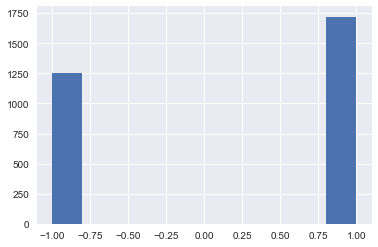

In [550]:
plt.hist(y_pred)

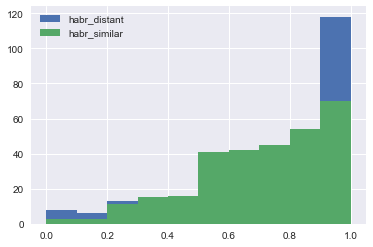

In [569]:
#plt.hist(postnauka_X[y_pred == -1]["ADJF"][:300], label="pn")
plt.hist(train_X[train_y == -1]["small_paragraphs_ratio"][:300], label="habr_distant")
plt.hist(train_X[train_y == +1]["small_paragraphs_ratio"][:300], label="habr_similar")
plt.legend()

## Экспорт

In [55]:
from ipywidgets import FloatProgress
from IPython.display import display

In [23]:
alg = pickle.load(open("best_classifier.dump", "rb"))

In [69]:
%%time

export_ids = list(almost_all_habrahabr_ids)
export_docs = list(map(get_document, export_ids))

CPU times: user 40.4 s, sys: 17.8 s, total: 58.2 s
Wall time: 1min 24s


In [70]:
%%time

morph = pymorphy2.MorphAnalyzer()

docs_info = []

counter = 0

progress = FloatProgress(min=0, max=len(export_ids))
display(progress)

for doc in export_docs:
    text = doc["markdown"]
    tokens = re.findall(r"[\w']+", text)
    doc_features = dict(zip(morph_tags, np.zeros(len(morph_tags))))
    npro1 = 0
    for token in tokens:
        parse_result = morph.parse(token)[0]
        for tag in doc_features.keys():
            if tag in parse_result.tag:
                doc_features[tag] += 1
            if {"NPRO", "1per"} in parse_result.tag:
                npro1 += 1
    doc_features["NPRO1"] = npro1

    doc_features["verbs_in_title"] = 0
    for token in re.findall(r"[\w']+", doc["title"]):
        parse_result = morph.parse(token)[0]
        if ({"VERB", "past"} in parse_result.tag) | ({"VERB", "futr"} in parse_result.tag): 
            doc_features["verbs_in_title"] += 1
            
    doc_features["verbs_in_first_pars"] = 0
    first_paragraphs = text.split("\n")[0]
    for token in re.findall(r"[\w']+", first_paragraphs):
        parse_result = morph.parse(token)[0]
        if ({"VERB", "past"} in parse_result.tag) | ({"VERB", "futr"} in parse_result.tag): 
            doc_features["verbs_in_first_pars"] += 1
        
    docs_info.append(doc_features)
        
    counter += 1
    #if counter % 1000 == 0:
    #    print("proceded: %d"%((counter)))
    
    progress.value += 1
    
habr_morph_features = pd.DataFrame(data=docs_info, index=export_ids)

CPU times: user 5h 25min 6s, sys: 2min 15s, total: 5h 27min 22s
Wall time: 5h 28min 1s


In [71]:
%%time

docs_info = []
docs_texts = []

pipeline = arbitrary.get_pipeline()

counter = 0

for doc in export_docs:
    doc_features = {}
    text = doc["modalities"]["text"] + doc["modalities"]["text_habr"]
    # Количественные признаки
    doc_features["words_count"] = len(text) # Число слов в документе
    doc_features["unique_words_ratio"] = len(set(text))/len(text)
    doc_features["common_words_ratio"] = len(doc["modalities"]["text"]) / len(text) # Доля токенов в документе из ПН
    doc_features["en_words"] = len([a for a in text if regex.match("^[a-zA-Z]+$", a)])/len(text)
    doc_features["ru_words"] = len([a for a in text if regex.match("^[а-яА-Я]+$", a)])/len(text)
    doc_features["non_letters"] = len([a for a in doc["markdown"] if a in non_letters])/len(doc["markdown"])
    doc_features["non_scipop_words"] = len([a for a in text if a in non_scipop_words])
    doc_features["scipop_words"] = len([a for a in text if a in scipop_words])
    # Параграфы и их длины
    doc_features["num_of_paragraphs"] = len([a for a in doc["markdown"].split('\n') if len(a) != 0])
    doc_features["paragraph_raito"] = doc_features["num_of_paragraphs"] / len(text)
    doc_features["avg_paragraph_len"] = np.mean([len(a) for a in doc["markdown"].split('\n') if len(a) != 0])
    doc_features["num_of_small_paragraphs"] = sum([1 for a in doc["markdown"].split('\n')
                                               if len(a) < 300 and len(a) > 0 or len(a.split(" ")) < 30])
    doc_features["num_of_large_paragraphs"] = sum([1 for a in doc["markdown"].split('\n')
                                               if len(a) > 1300 or len(a.split(" ")) > 120])
    doc_features["small_paragraphs_ratio"] = doc_features["num_of_small_paragraphs"]/doc_features["num_of_paragraphs"]
    doc_features["large_paragraphs_ratio"] = doc_features["num_of_large_paragraphs"]/doc_features["num_of_paragraphs"]
    doc_features["paragraphs_variance"] = np.var([len(s) for s in doc["markdown"].split('\n') if len(s) != 0])

    # Фичи заголовков:
    
    #doc_features["code_ratio"] = len([a for a in doc["markdown"].split("\t") if a in code_elements])/len(doc["markdown"])
    docs_info.append(doc_features)
    docs_texts.append(text)
    
habr_X = pd.DataFrame(data=docs_info, index=export_ids)

CPU times: user 3min 45s, sys: 12.8 s, total: 3min 57s
Wall time: 3min 59s


In [72]:
habrahabr_X = pd.concat([habr_X, habr_morph_features], axis=1)

In [73]:
prediction = alg.predict_proba(habrahabr_X[good_features])
output = pd.DataFrame(pd.Series(prediction.T[1], index=export_ids), columns=["proba"])
len(output[output.proba > 0.5])

14951

In [74]:
output.to_csv(EXPORT_PATH)

---